In [1]:
import torch
from PIL import Image
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

image = preprocess(Image.open("breakout.webp")).unsqueeze(0)
# text = tokenizer(["a diagram", "a dog", "a cat"])
print(image.shape)

with torch.no_grad():
    image_features = model.encode_image(image)

print("feature vector:", image_features.shape)  # prints: [[1., 0., 0.]]

torch.Size([1, 3, 224, 224])
feature vector: torch.Size([1, 512])


In [2]:
image_features.shape

torch.Size([1, 512])

In [3]:
image = torch.randn(1, 3, 224, 224)
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)

print("feature vector:", image_features.shape)  # prints: [[1., 0., 0.]]

feature vector: torch.Size([1, 512])


/Users/paul/dev/muzero/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [4]:
import torchvision

# import video
vid = torchvision.io.read_video("rl-video-episode-0 copy.mp4")
frames = vid[0]

/Users/paul/dev/muzero/.venv/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [5]:
frames.shape

torch.Size([96, 210, 160, 3])

In [6]:
from torchvision.transforms.v2 import Compose, Resize, Normalize, ToTensor, ToImage
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size(), device=tensor.device) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

mean = [0.48145466, 0.4578275, 0.40821073]
std = [0.26862954, 0.26130258, 0.27577711]

preprocess = Compose([
    ToImage(),
    Resize((224, 224)),
    AddGaussianNoise(0., 0.02),
    Normalize(mean=mean, std=std),
    ToTensor()
])

/Users/paul/dev/muzero/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [7]:
import matplotlib.pyplot as plt

preprocessed_frames = preprocess((frames / 255.0).permute(0, 3, 1, 2))

In [8]:
embedded = model.encode_image(preprocessed_frames)

In [9]:
embedded.shape

torch.Size([96, 512])

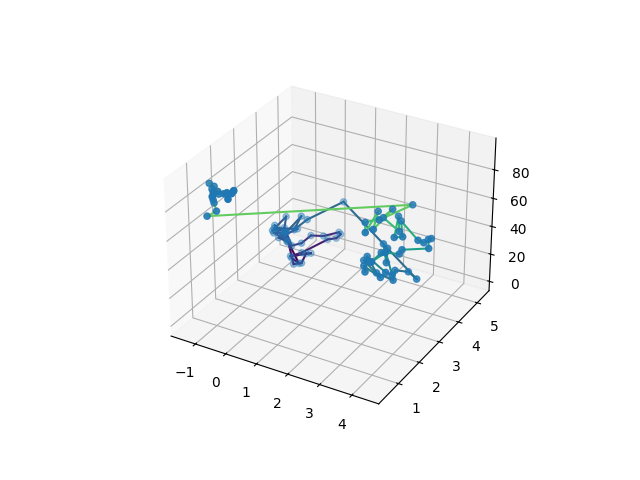

In [10]:
# tsne decomposition to project into 2D
%matplotlib ipympl
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=42)
embedded_2d = tsne.fit_transform(embedded.cpu().detach().numpy())

# 3D plot with time on z-axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedded_2d[:, 0], embedded_2d[:, 1], range(len(embedded_2d)))
# plot a line between each point and the next with a color gradient
for i in range(len(embedded_2d) - 1):
    ax.plot(embedded_2d[i:i+2, 0], embedded_2d[i:i+2, 1], [i, i+1], color=plt.cm.viridis(i / len(embedded_2d)))

plt.show()

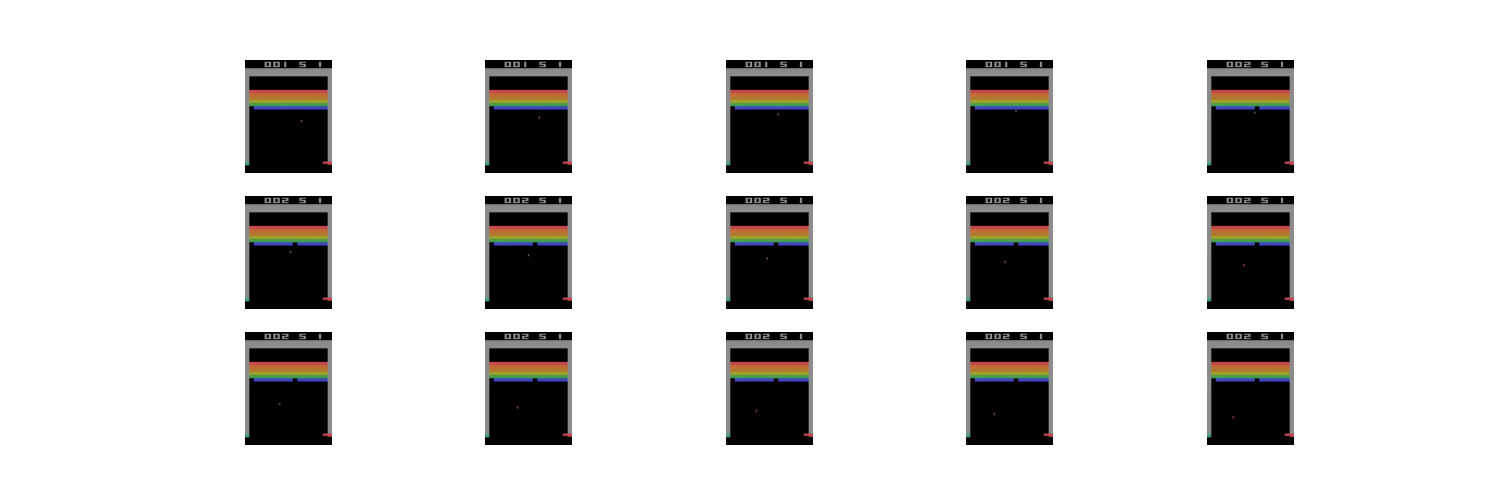

In [12]:

# show frames between 25 and 35 in 2 rows
fig, axs = plt.subplots(3, 5, figsize=(15, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(frames[i + 70])
    ax.axis("off")


In [13]:
f1 = embedded[74]
f2 = embedded[75]
f3 = embedded[76]

In [14]:
# angle between f1 and f2
angle12 = torch.nn.functional.cosine_similarity(f1, f2, dim=0)
angle23 = torch.nn.functional.cosine_similarity(f2, f3, dim=0)
(angle12, angle23)

(tensor(0.9872, grad_fn=<SumBackward1>),
 tensor(0.9893, grad_fn=<SumBackward1>))

In [15]:
# angle between first and rest of the frames
angles = torch.nn.functional.cosine_similarity(embedded, embedded[0].unsqueeze(0), dim=1)

In [16]:
angles

tensor([1.0000, 0.9941, 0.9904, 0.9949, 0.9940, 0.9939, 0.9922, 0.9935, 0.9915,
        0.9846, 0.9742, 0.9775, 0.9743, 0.9883, 0.9881, 0.9922, 0.9945, 0.9920,
        0.9956, 0.9924, 0.9945, 0.9926, 0.9938, 0.9943, 0.9940, 0.9945, 0.9937,
        0.9925, 0.9870, 0.9943, 0.9926, 0.9939, 0.9917, 0.9917, 0.9722, 0.9460,
        0.9618, 0.9562, 0.9609, 0.9667, 0.9718, 0.9602, 0.9657, 0.9672, 0.9723,
        0.9657, 0.9591, 0.9661, 0.9675, 0.9693, 0.9609, 0.9623, 0.9631, 0.9636,
        0.9674, 0.9633, 0.9534, 0.9492, 0.9487, 0.9440, 0.9546, 0.9585, 0.9645,
        0.9702, 0.9611, 0.9613, 0.9749, 0.9691, 0.9668, 0.9654, 0.9635, 0.9641,
        0.9627, 0.9553, 0.9598, 0.9651, 0.9600, 0.9673, 0.9695, 0.9700, 0.9694,
        0.9640, 0.9690, 0.9667, 0.9680, 0.9704, 0.9727, 0.9701, 0.9712, 0.9652,
        0.9640, 0.9606, 0.9628, 0.9607, 0.9606, 0.9402],
       grad_fn=<SumBackward1>)

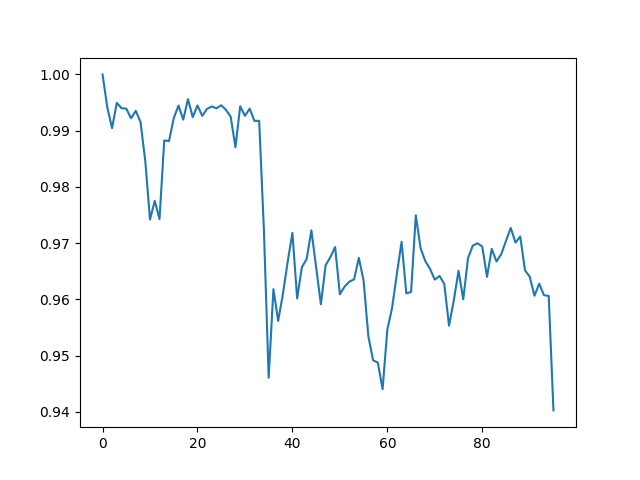

In [17]:
# plot angles along time
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(angles.cpu().detach().numpy())
plt.show()

In [18]:
# angle difference between consecutive frames
angle_diff = torch.nn.functional.cosine_similarity(embedded[:-1], embedded[1:], dim=1)

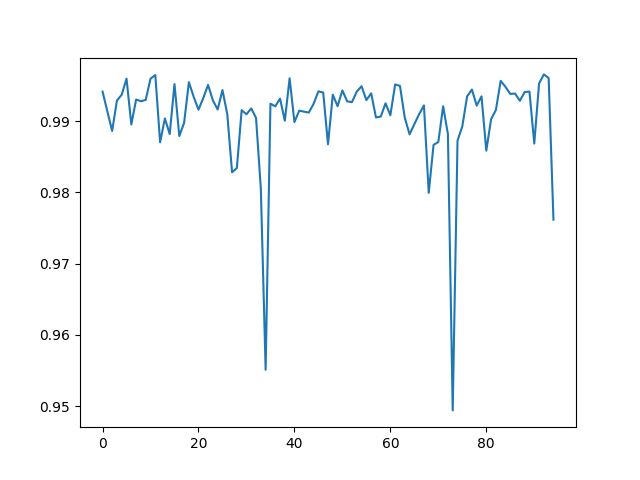

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(angle_diff.cpu().detach().numpy())
plt.show()

# Representation network Definition

- encode stack of images
- add positional encoding to stack of representation vectors
- attention over the postionally encoded representation vectors
- project attention outputs into hidden state

In [65]:
import torch.nn as nn
import torch.nn.functional as F
import math

class VitConfig:
    def __init__(self, base_model: str = 'ViT-B-32', pretrained: str = 'laion2b_s34b_b79k'):
        self.base_model = base_model
        self.pretrained = pretrained

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        # print("positional encoding -> d_model: ", d_model)
        # print("positional encoding -> max_seq_length: ", max_seq_length)
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        # print("pe shape: ", self.pe.shape)
        # print("positional encoding -> x shape: ", x.shape)
        return x + self.pe[:, :x.size(1)]


class RepresentationViTGeneral(nn.Module):
    def __init__(self, hidden_dim: int, num_planes: int, seq_len: int, attention_heads: int, config: VitConfig):
        super().__init__()
        self.input_size = 512 # feature vector length
        self.encoder, _, _ = open_clip.create_model_and_transforms(config.base_model, pretrained=config.pretrained)
        self.preprocess = Compose([
            ToImage(),
            Resize((224, 224), antialias=False),
            AddGaussianNoise(0., 0.01),
            Normalize(mean=mean, std=std),
            ToTensor()
        ])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.attention_block = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=attention_heads)
        # self.attention_block_out_proj = nn.Linear(, hidden_dim)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, num_planes),
            nn.ReLU(),
            nn.Linear(num_planes, hidden_dim),
        )
        self.positional_encoding = PositionalEncoding(self.input_size, seq_len)
        # self.layernorm = nn.LayerNorm(hidden_dim)
        self.seq_len = seq_len


In [21]:
represent = RepresentationViTGeneral(512, 512, 64, 8, VitConfig())

/Users/paul/dev/muzero/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [22]:
input = frames[:64] / 255.0

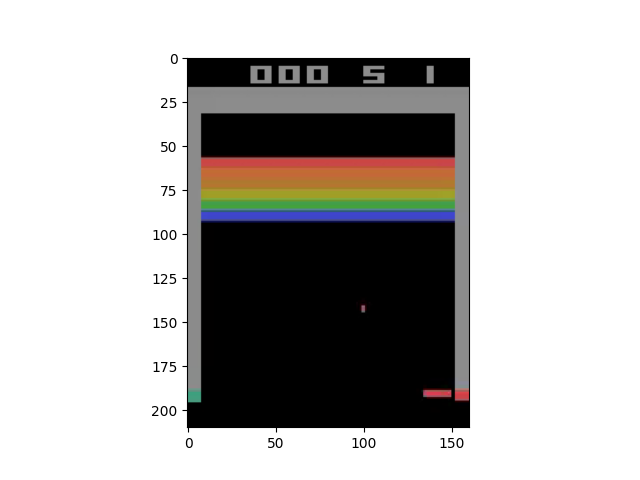

In [23]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(input[0])
plt.show()

In [24]:
x = input.permute(0, 3, 1, 2)

In [25]:
x = x.reshape(-1, x.shape[2], x.shape[3])
x.shape

torch.Size([192, 210, 160])

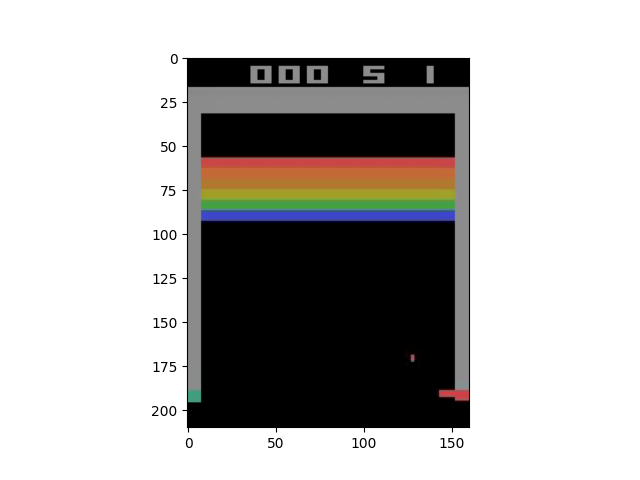

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(x[21:24].permute(1, 2, 0))
plt.show()

In [27]:
x = x.unsqueeze(0)


In [28]:
x.shape

torch.Size([1, 192, 210, 160])

In [29]:


B, C, H, W = x.shape
print(f"B: {B}, C: {C}, H: {H}, W: {W}")
assert C // represent.seq_len == 3

B: 1, C: 192, H: 210, W: 160


In [30]:
y = x.view(B * represent.seq_len, 3, H, W)

In [31]:
y.shape

torch.Size([64, 3, 210, 160])

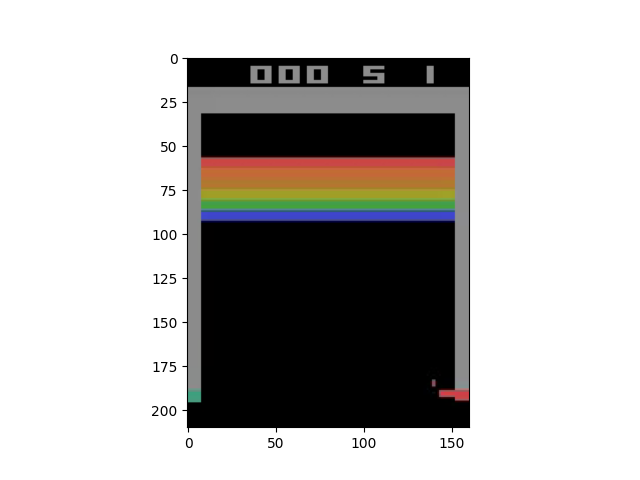

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(y[12].permute(1, 2, 0))
plt.show()

In [33]:
w = represent.preprocess(y)

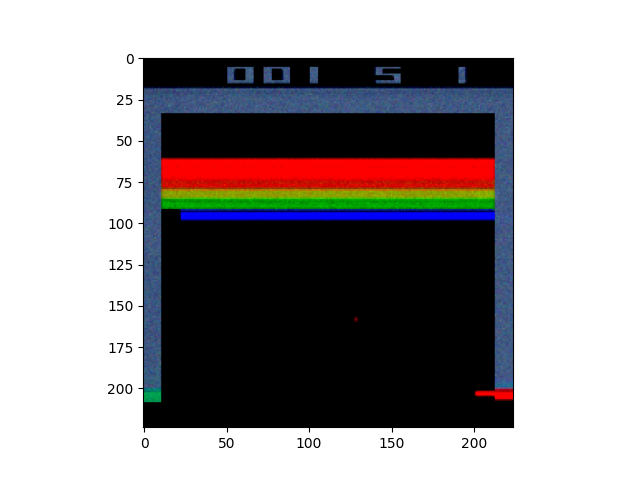

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(w[48].permute(1, 2, 0))
plt.show()

In [35]:
e = represent.encoder.encode_image(w)

In [36]:
e.shape

torch.Size([64, 512])

In [37]:
u = e.view(B, represent.seq_len, -1)

In [38]:
u.shape

torch.Size([1, 64, 512])

In [39]:
v = represent.positional_encoding(u)

In [40]:
v.shape

torch.Size([1, 64, 512])

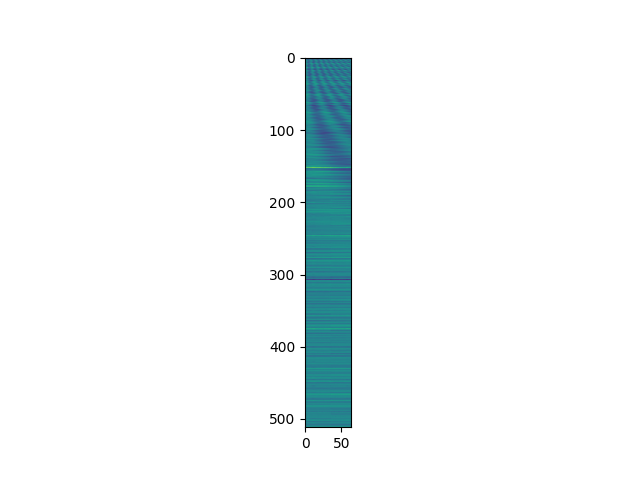

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(v[0].permute(1, 0))
plt.show()

## Rotary Embeddings

In [42]:
def apply_rotary_positional_encoding(x: torch.Tensor, pos: torch.Tensor):
    d = x.shape[-1]
    half_dim = d // 2
    theta = pos / torch.pow(10000, (2 * (torch.arange(half_dim)) / d))
    
    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)
    
    x_even = x[..., 0::2]
    x_odd = x[..., 1::2]
    
    x_rotated_even = cos_theta * x_even - sin_theta * x_odd
    x_rotated_odd = sin_theta * x_even + cos_theta * x_odd
    
    x_rotated = torch.empty_like(x)
    x_rotated[..., 0::2] = x_rotated_even
    x_rotated[..., 1::2] = x_rotated_odd
    
    return x_rotated

In [43]:
u.shape

torch.Size([1, 64, 512])

In [44]:
v2 = apply_rotary_positional_encoding(u, torch.arange(u.shape[1]).unsqueeze(-1))

In [45]:
v2.shape

torch.Size([1, 64, 512])

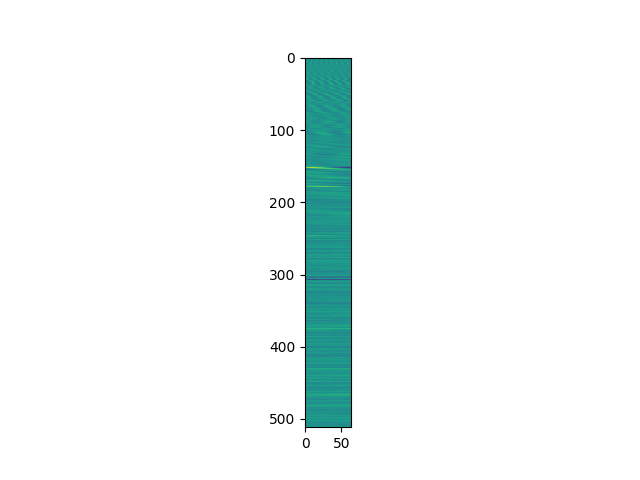

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(v2[0].permute(1, 0))
plt.show()

In [47]:
transformer = nn.TransformerEncoder(
    nn.TransformerEncoderLayer(d_model=512, nhead=8),
    num_layers=3
)

transformer_out = transformer(v2)

/Users/paul/dev/muzero/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [48]:
transformer_out.shape

torch.Size([1, 64, 512])

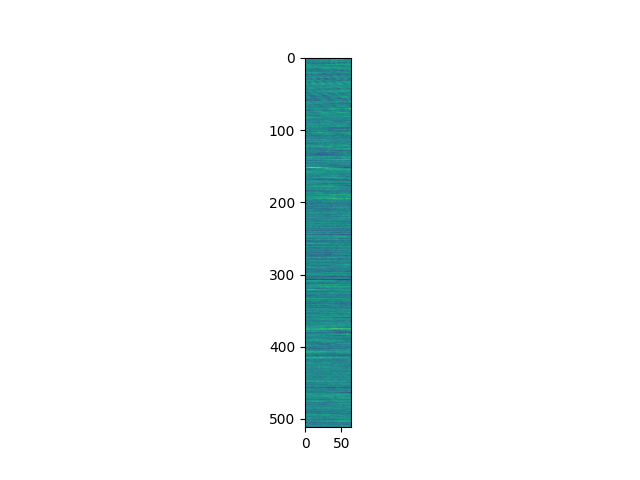

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(transformer_out[0].permute(1, 0).detach().numpy())
plt.show()

In [50]:
pooling = nn.AdaptiveAvgPool1d(1)


In [51]:
transformer_out.shape

torch.Size([1, 64, 512])

In [52]:
z = pooling(transformer_out.permute(0, 2, 1))

In [55]:
proj = nn.Sequential(
            nn.Linear(512, 10),
            nn.ReLU(),
            nn.Linear(10, 512),
        )

In [56]:
t = proj(z.squeeze(-1))

In [57]:
t.shape

torch.Size([1, 512])

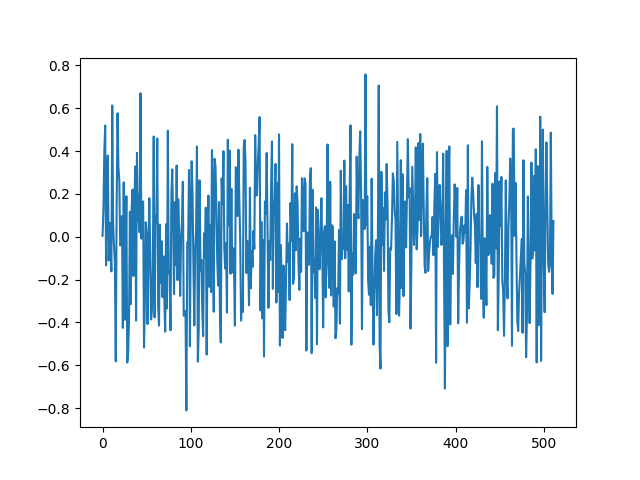

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0].detach().numpy())
plt.show()

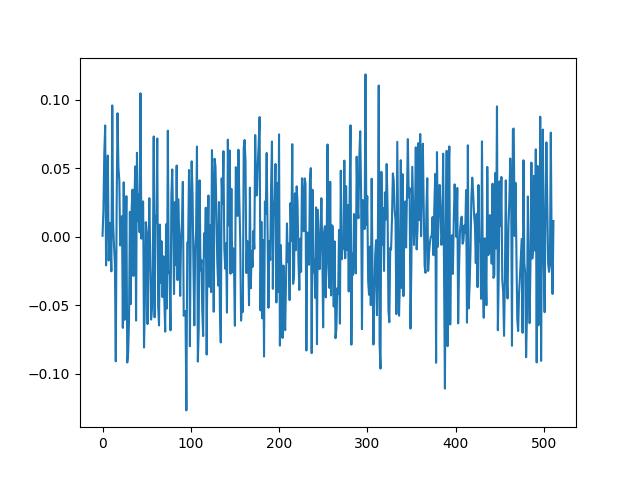

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(F.normalize(t, p=2, dim=1)[0].detach().numpy())
plt.show()

In [59]:
proj_2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
)

In [60]:
t2 = proj_2(z.squeeze(-1))

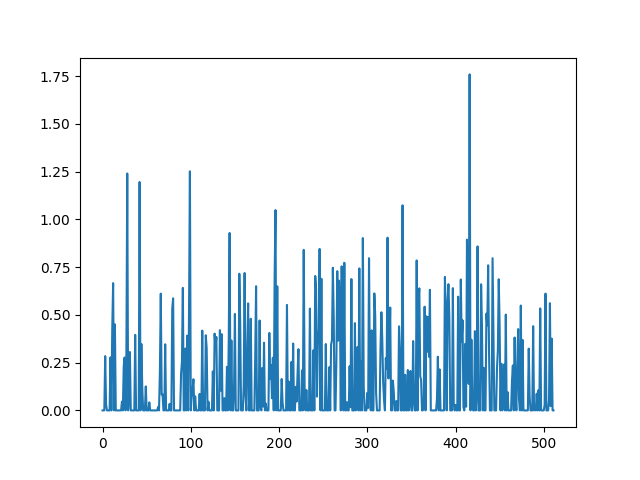

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t2[0].detach().numpy())
plt.show()